In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt

In [6]:
# Custom Loss Function with Covariance Penalty
def custom_loss(lam, cov_real_data):
    def loss(y_true, y_pred):
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        cov_pred = tf.linalg.matmul(tf.transpose(y_pred - tf.reduce_mean(y_pred, axis=0)), 
                                    (y_pred - tf.reduce_mean(y_pred, axis=0))) / tf.cast(tf.shape(y_pred)[0], tf.float32)
        cov_penalty = tf.reduce_sum(tf.square(cov_pred - cov_real_data))
        return mse_loss + lam * cov_penalty
    return loss

def load_model_and_preprocessors(model_path, cov_real_data_path, scaler_X_path, scaler_y_path):
    # Load the covariance matrix
    cov_real_data = np.load(cov_real_data_path)
    
    # Load the trained model
    model = tf.keras.models.load_model(model_path, custom_objects={'loss': custom_loss(1e-6, cov_real_data)})
    
    # Load the input data scaler
    scaler_X = joblib.load(scaler_X_path)
    
    # Load the output data scaler
    scaler_Y = joblib.load(scaler_y_path)
    
    return model, scaler_X, scaler_Y

In [7]:
# Step 1: Read the Dataset
file_path = r'C:\Users\Administrator\Desktop\training data\test\almond.csv'
if file_path.endswith('.csv'):
    dataset = pd.read_csv(file_path)
elif file_path.endswith('.xlsx'):
    dataset = pd.read_excel(file_path)
else:
    raise Exception("Invalid file format. Please provide a .csv or .xlsx file.")


feature_columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
# Extract input features from the dataset using the specified column labels
X = dataset[feature_columns].values
X

array([[ 535.1785714,  696.4818841, 1274.86     , ..., 5214.068627 ,
        3024.76     , 1444.093607 ],
       [ 346.7714286,  475.8086957, 1103.664    , ..., 5181.552941 ,
        3190.96     , 1576.208219 ],
       [ 482.5238095,  617.9565217, 1153.02     , ..., 5253.343137 ,
        3217.166667 , 1634.009132 ],
       ...,
       [ 824.2261905, 1052.648551 , 1914.3      , ..., 5998.196079 ,
        4334.32     , 2675.363014 ],
       [ 834.4      , 1043.104348 , 1831.952    , ..., 5432.129412 ,
        3546.344    , 2019.153425 ],
       [ 840.2738095, 1065.373188 , 1890.053333 , ..., 5717.803922 ,
        3999.066667 , 2381.257991 ]])

In [8]:
# Step 2: Data Preprocessing
# Load model and preprocessors
model, loaded_scaler_X, loaded_scaler_Y = load_model_and_preprocessors(
    r"C:\Users\Administrator\Desktop\training data\model\model",
    r"C:\Users\Administrator\Desktop\training data\model\cov_real_data.npy",
    r"C:\Users\Administrator\Desktop\training data\model\scaler_X.pkl",
    r"C:\Users\Administrator\Desktop\training data\model\scaler_y.pkl"
)
# Scale the input data using the loaded input data scaler
scaled_X = loaded_scaler_X.transform(X)

In [9]:
# Step 3: Use the Model to Make Predictions
# Use the loaded model to predict the scaled input data
predictions_scaled = model.predict(scaled_X)

# Step 4: Postprocessing the Predictions
# Transform the scaled predictions back to the original data range using the loaded output data scaler
predictions = loaded_scaler_Y.inverse_transform(predictions_scaled)

predictions

10/10 [==============================] - 2s 2ms/step


array([[2.0426469e+00, 5.5741692e+01, 1.1936900e+01, 1.6679956e-02,
        9.0555446e-03],
       [1.9179082e+00, 5.1137451e+01, 1.2264717e+01, 1.4543690e-02,
        9.4205691e-03],
       [2.0876808e+00, 5.8667747e+01, 1.2511280e+01, 1.3919727e-02,
        8.8746920e-03],
       ...,
       [2.7069459e+00, 4.5013268e+01, 8.7425776e+00, 7.7592623e-03,
        7.6917689e-03],
       [2.1020155e+00, 3.6001743e+01, 7.4180202e+00, 1.0543707e-02,
        6.0770353e-03],
       [2.4238467e+00, 4.0730759e+01, 7.9681959e+00, 8.5495552e-03,
        6.8527958e-03]], dtype=float32)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22828\3248826110.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axarr[row, col].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, color='red')


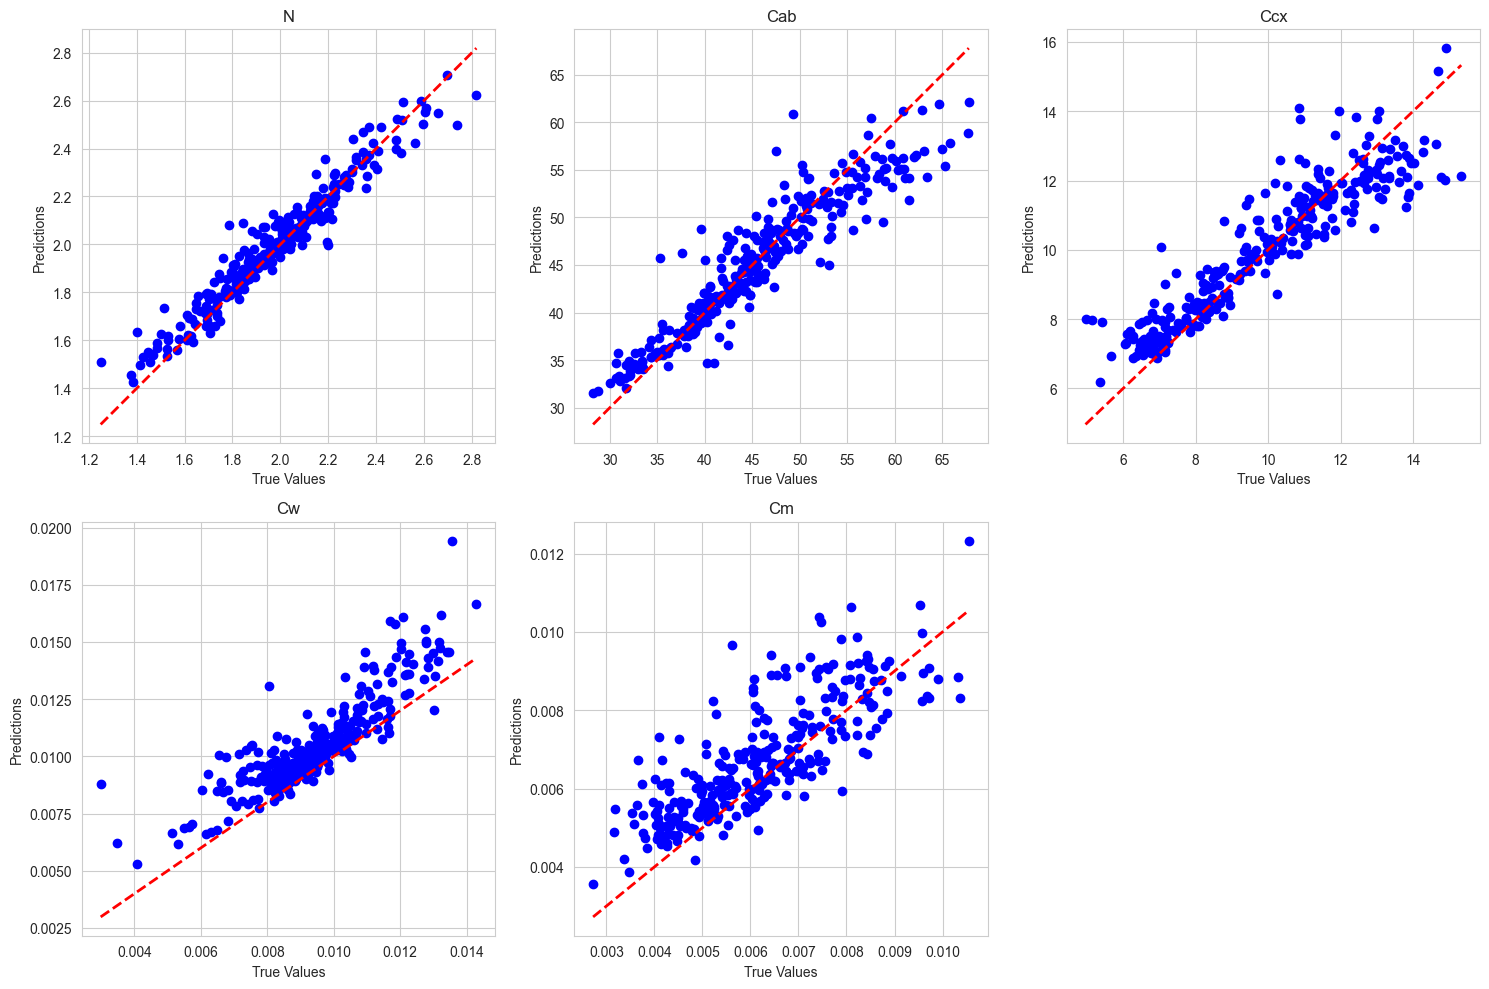

In [11]:
# Step 5: Compare and Visualize

output_labels = ["N", "Cab", "Ccx", "Cw", "Cm"]

# Number of rows and columns for the subplots
n_rows = 2
n_cols = 3

# Create a new figure and a grid of subplots
fig, axarr = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Loop through the output labels and plot each scatter plot in its own subplot
for i, label in enumerate(output_labels):
    row = i // n_cols
    col = i % n_cols
    
    if label in dataset.columns:
        y_true = dataset[label].values
        y_pred = predictions[:, i]
        
        # Scatter plot in the subplot
        axarr[row, col].scatter(y_true, y_pred, c='blue')
        axarr[row, col].set_title(f'{label}')
        axarr[row, col].set_xlabel('True Values')
        axarr[row, col].set_ylabel('Predictions')
        axarr[row, col].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, color='red')
        axarr[row, col].grid(True)

# Hide any remaining empty subplots
for i in range(len(output_labels), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axarr[row, col].axis('off')

# Display the figure with subplots
plt.tight_layout()
plt.show()